# Restauration d'image à l'aide de l'ADMM

Infos : 
- Ce notebook est en python 3.
- J'utilise l'opérateur @ pour les multiplications matricielles ( A @ B = A.dot(B) ) 


## Manipulation 1

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# Ouvrir des données stockées dans un fichier .pk
data = pickle.load(open('data2018.pk','rb'))

#ou
#data = pickle.load(open('data2018_for_python2.pk','rb'), encoding='latin1')
# Charger par exemple la matrice H
H = data.get('H')
T = data.get('T')
T = np.array(T.todense())
observations = data.get('observations')
original = data.get('original')
filtre = data.get('filtre')
# Sauvegarder des données dans un fichier .pk
#pickle.dump({'obj1': obj1, 'obj2':obj2}, open('filename.pk','wb'), pickle.HIGHEST_PROTOCOL)

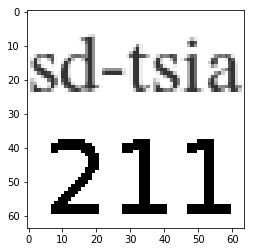

In [2]:
plt.imshow(original, cmap='gray')

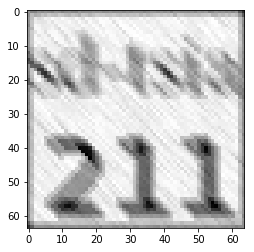

In [3]:
plt.imshow(observations, cmap='gray')

## Préparation 1

On prend :

$ f(x) = \frac{1}{2} \| y - Hx \|_2^2$

$ g(z_1, z_2) = 1_{[0, 1]}(z_1) + \beta \|z_2\|_1$

$ z = {\begin{pmatrix}x\\Tx\end{pmatrix}} $

$ A = {\begin{pmatrix}I_{P}\\T\end{pmatrix}} $ avec $ P = 64 \times 64$

##### Création de la matrice A : 

In [4]:
from scipy.sparse import csr_matrix

y = observations.reshape(-1)
x_original = original.reshape(-1)

P = observations.shape[0] * observations.shape[1] 

I = np.identity(P)
A = np.concatenate((I, T))
A = csr_matrix(A)

## Préparation 2

$L_p(x, z, \gamma) = \frac{1}{2} \| y - Hx \|_2^2 + 1_{[0, 1]}(z_1) + \beta \|z_2\|_1 + <\gamma, Ax - z> + \frac{\rho}{2} \|Ax - z\|_2^2 $

## Préparation 3, 4 et 5

Tout d'abord, on peut ré-écrire les equations (7), (8) et (9)

$$ x^{k+1} =  {\underset {x}{\operatorname {argmin} }} \frac{1}{2} \| y - Hx \|_2^2  + {\gamma_1^k}^{\mathsf T} (x - z_1^k) + {\gamma_2^k} ^{\mathsf T} (Tx - z_2^k)
+ \frac{\rho}{2} \| Ax - z^k \|_2^2$$

$$ z_1 ^{k+1} =  {\underset {z_1}{\operatorname {argmin} }}1_{[0, 1]^P}(z_1) + {\gamma_1^k}^{\mathsf T} (x^{k+1} - z_1) + \frac{\rho}{2} \| x^{k+1} - z_1 \|_2^2 $$

$$ z_2 ^{k+1} = argmin_{z_1} \beta \| z_2 \|_1 + \gamma_2 ^{\mathsf T} (Tx - z_2) + \| Tx - z_2 \|_2^2 $$

$$ \gamma_1^{k+1} = \gamma_1^{k} + \rho (x^{k+1} - z_1^{k+1}) $$

$$ \gamma_2^{k+1} = \gamma_2^{k} + \rho (Tx^{k+1} - z_2) $$ 

On retravaille ensuite les expressions : 

**Préparation 3 : mise à jour de $x$**

$x \mapsto \frac{1}{2} \| y - Hx \|_2^2  + <{\gamma_1^k}, x - z_1^k> + <\gamma_2^k, Tx - z_2^k> 
+ \frac{\rho}{2} \| Ax - z^k \|_2^2$ est convexe comme somme de normes 2 et de fonctions linéaires.

Il suffit donc d'annuler le gradient pour trouver un argmin. Ce qui donne :

$ H ^{\mathsf T} (Hx - y) + \rho A ^{\mathsf T} (Ax - z) + \gamma_1 + T^{\mathsf T}\gamma_2 = 0$

Soit : $ (H ^{\mathsf T} H + \rho A^{\mathsf T}A)x = H^{\mathsf T}y + \rho A^{\mathsf T}z - \gamma_1 - T^{\mathsf T} \gamma_2 $

On pourra utiliser la méthode du gradient conjugué pour résoudre ce système car $ (H ^{\mathsf T} H + \rho A^{\mathsf T}A)$ est symétrique, définie, positive.


** Préparation 4 : mise à jour de $z_1$ **

$ \frac{\rho}{2}  \| x^{k+1} - z_1 \|^2 - <\gamma_1^k, z_1> = \frac{\rho}{2} \| z_1 \| ^2 - <\rho x^{k+1} + \gamma_1 ^k, z_1 > + \frac{\rho}{2} \|x^{k+1}\| = \frac{\rho}{2} \| ( x^{k+1} + \frac{1}{\rho} \gamma_1 ^ k) - z_1 \|^2 -  \frac{\rho}{2} \| x^{k+1} + \frac{1}{\rho} \gamma_1 ^ k \| ^2 +  \frac{\rho}{2} \|x ^ {k+1} \|^2 $

Les termes  $\frac{\rho}{2} \| x^{k+1} + \frac{1}{\rho} \gamma_1 ^ k \| ^2$ et $ \frac{\rho}{2} \|x ^ {k+1} \|^2 $ ne dépendent pas de $z_1$ donc on peut les éliminier de l'argmin.

On obtient ainsi :

$z_1^{k+1} = argmin_{z_1}  1_{[0, 1]^P}(z_1) + \frac {\rho}{2} \| x ^ {k+1} + \frac{1}{\rho}  \gamma_1 ^k - z_1 \| ^ 2$

$ = argmin_{z_1} \frac{1}{\rho}  1_{[0, 1]^P}(z_1) + \frac {1}{2} \| x ^ {k+1} + \frac{1}{\rho}  \gamma_1 ^k - z_1 \| ^ 2$

$ = prox_{\frac{1}{\rho}  1_{[0, 1]^P}} (x^{k+1} + \frac{1}{\rho}  \gamma_1 ^k ) $

$ = prox_{ 1_{[0, 1]^P}} (x^{k+1} + \frac{1}{\rho}  \gamma_1 ^k ) $ car $\frac{1}{\rho}  1_{[0, 1]^P} = 1_{[0, 1]^P}$

$ = proj_{[0, 1]^P} (x^{k+1} + \frac{1}{\rho}  \gamma_1 ^k ) $

Cette dernière expression est facile à calculer.

** Préparation 4 : mise à jour de $z_2$ **

Par un calcul similaire, on obtient : 

$z_2^{k+1} = argmin_{z_2} \frac{\beta}{\rho}  \|z_2\|_1 + \frac {1}{2} \| x ^ {k+1} + \frac{1}{\rho}  \gamma_2 ^k - z_2 \| ^ 2$

$ = prox_{ \frac{\beta}{\rho} \|.\|_1} (Tx^{k+1} + \frac{1}{\rho}  \gamma_2 ^k)$

Cette dernière expression est également facile à calculer.

## Manipulation 2

In [5]:
rho = 0.01
beta = 0.01
k_max = 100

In [6]:
def proj01_1D(x):
    """projection d'un réel sur [0, 1]"""
    if(x < 0):
        return 0.
    elif(x > 1):
        return 1.
    else:
        return x

#projection d'un vecteur sur [0, 1]^P
proj01_P = np.vectorize(proj01_1D)

def prox_abs(x, gamma):
    """opérateur proximal de la fonction valeur absolue"""
    if(x < -gamma):
        return x + gamma
    elif(x > gamma):
        return x - gamma
    else:
        return 0.

prox_gamma_norm1 = lambda gamma : np.vectorize(lambda x : prox_abs(x, gamma))
#prox_gamma_norm1(2) est une fonction correspond au prox de 2||.||_1
#prox_gamma_norm1(2)(v) est l'application du prox de 2||.||_1 à v

In [7]:
from scipy.sparse.linalg import cg as conjugate_gradient

def ADMM_step(x, z1, z2, gamma1, gamma2, beta, rho, S=None):
    if(S is None):
        S = H.T @ H + rho * A.T @ A
    z = np.concatenate((z1, z2))
    x, info = conjugate_gradient(S, H.T @ y + rho * A.T @ z - gamma1 - T.T @ gamma2)
    z1 = proj01_P(x + gamma1 / rho)
    z2 = prox_gamma_norm1(beta/rho)(T @ x + gamma2 /rho)
    gamma1 += rho * (x - z1)
    gamma2 += rho * (T @ x - z2)
    return x, z1, z2, gamma1, gamma2

from numpy.linalg import norm

def ADMM(x, z1, z2, gamma1, gamma2, beta, rho):
    eqms = []
    S = H.T @ H + rho * A.T @ A
    for k in range(k_max):
        x, z1, z2, gamma1, gamma2 = ADMM_step(x, z1, z2, gamma1, gamma2, beta, rho, S)
        eqms.append(norm(x_original - x))
    return eqms, x

## Manipulation 3

### Affichage de l'EQM

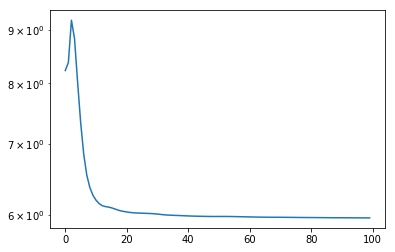

In [8]:
#initialisation :
x0 = np.ones_like(y)
z0_1 = x0.copy()
z0_2 = T @ x0
gamma0_1 = np.zeros_like(z0_1)
gamma0_2 = np.zeros_like(z0_2)

eqms, x_corr = ADMM(x0, z0_1, z0_2, gamma0_1, gamma0_2, beta, rho)
plt.semilogy([k for k in range(k_max)], eqms)

### Affichage de la reconstitution

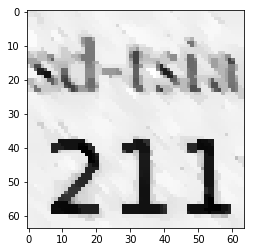

In [9]:
plt.imshow(x_corr.reshape(observations.shape), cmap='gray')

In [10]:
print("Le biais est de : %g" % np.abs(x_original - x_corr).sum())
print("Soit une fois normalisé : %g" % (np.abs(x_original - x_corr).sum() / P))

Le biais est de : 258.531
Soit une fois normalisé : 0.0631179


## Manipulation 4

In [11]:
class ProgressBar:
    """
    classe permettant d'afficher une progresse bar à base de #
    (pas vraiment de rapport avec le TP, mais utile pour voir où ça en est)
    """
    
    
    def __init__(self):
        self.progress = 0
        print("["+"-"*100+"]")
        print("[", end="")
    
    def update(self, new_progress):
        """new_progress doit représenter le pourcentage d'avancement (entre 0 et 1)"""
        new_progress = round(new_progress * 100)
        if(new_progress - self.progress > 0):
            print("#" * (new_progress - self.progress), end="")
            self.progress = new_progress
            if(new_progress == 100):
                print("]")

In [12]:
def draw_image_grid(beta_grid, rho_grid):
    n_b, n_r = len(beta_grid), len(rho_grid)
    fig, axes = plt.subplots(n_b, n_r)
    fig.set_size_inches(16, 19*len(beta_grid)/len(rho_grid))
    pb = ProgressBar()
    eqms_grid = [[None for k in range(n_r)] for j in range(n_b)]
    for i, beta in enumerate(beta_grid):
        for j, rho in enumerate(rho_grid):
            eqms, x_corr = ADMM(x0, z0_1, z0_2, gamma0_1, gamma0_2, beta, rho)
            eqms_grid[i][j] = eqms
            axes[i, j].imshow(x_corr.reshape(observations.shape), cmap='gray')
            axes[i, j].set_xlabel("eqm = %g, biais = %g" % (eqms[-1], np.abs(x_original - x_corr).sum()))
            axes[i, j].set_title("beta = %g, rho = %g" % (beta, rho))
            pb.update((i*n_r + j + 1) /(n_r * n_b))
    return eqms_grid

[----------------------------------------------------------------------------------------------------]
[####################################################################################################]


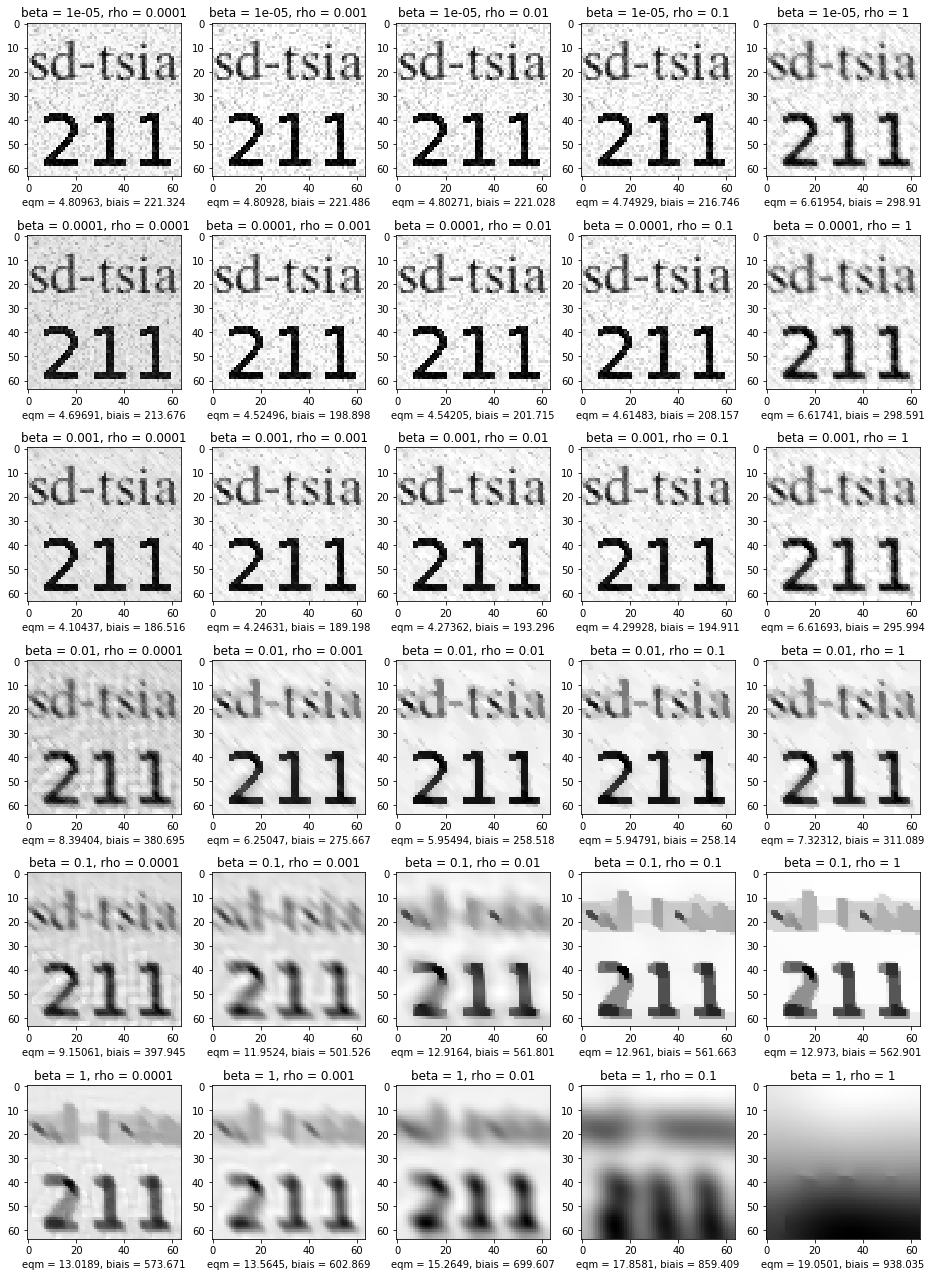

In [13]:
beta_grid = [10**-k for k in range(5, -1, -1)]
rho_grid =  [10**-k for k in range(4, -1, -1)]

eqms_grid = draw_image_grid(beta_grid, rho_grid)

Les 3 ou 4 premières lignes de ce quadrillage contiennent toutes des reconstructions de qualité correcte. On voit que c'est essentiellement $\beta$ qui joue un rôle sur la qualité de reconstruction. $\rho$ a un impact secondaire.

Ce quadrillage pousserait à prendre $\beta \leq 0.001 $ et $ \rho \in [0.001, 0.1]$ 

In [14]:
def draw_eqms_at_beta(eqms_grid, i, beta_grid, rho_grid):
    X = [k for k in range(len(eqms_grid[0][0]))]
    beta = beta_grid[i]
    ax = plt.subplot()
    for j, rho in enumerate(rho_grid):
        plt.plot(X, eqms_grid[i][j], label="rho = %g" % rho)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set_title("évolution de l'EQM, beta = %g" % beta)
    
def draw_eqms_at_rho(eqms_grid, j, beta_grid, rho_grid):
    X = [k for k in range(len(eqms_grid[0][0]))]
    rho = rho_grid[j]
    ax = plt.subplot()
    for i, beta in enumerate(beta_grid):
        plt.plot(X, eqms_grid[i][j], label="beta = %g" % beta)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set_title("évolution de l'EQM, rho = %g" % rho)

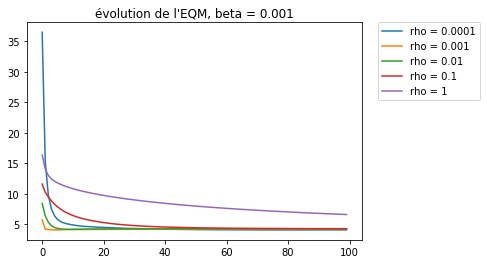

In [15]:
draw_eqms_at_beta(eqms_grid, 2, beta_grid, rho_grid)

Pour $\beta$ petit, on a une bonne convergence de l'EQM quelques soit rho. Cependant $\rho$ influe sur la vitesse de convergence.

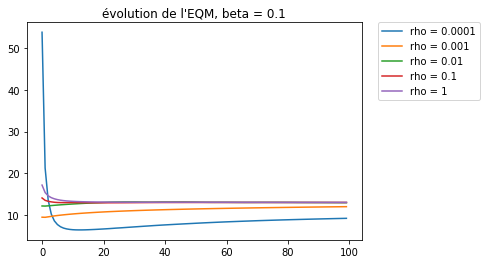

In [16]:
draw_eqms_at_beta(eqms_grid, 4, beta_grid, rho_grid)

Pour $\beta$ plus grand, l'EQM converge toujours mais vers des valeurs plus élevées.

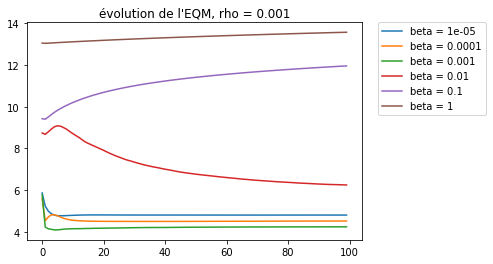

In [17]:
draw_eqms_at_rho(eqms_grid, 1, beta_grid, rho_grid)

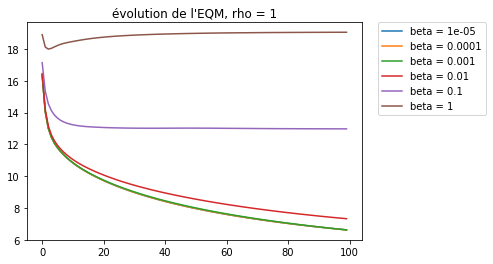

In [18]:
draw_eqms_at_rho(eqms_grid, 4, beta_grid, rho_grid)

Ces deux grahes nous montrent également que c'est $\beta$ qui a un réel impact sur l'EQM de convergence tandis que $\rho$ a un essentiellement un impact sur la vitesse de convergence. 

#### Conclusion :

Au vue des graphiques, et du quadrillage d'images reconstituées, on pourrait estimer que les meilleurs paramètre sont : $\beta = 0.001$ et $\rho = 0.01$